In [1]:
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline

In [2]:
img = io.read_image('puppy.jpg')
img_grey_gs = (0.2989*img[0,:,:] + 0.5870*img[1,:,:] + 0.1140*img[2,:,:]).type(torch.uint8)

In [3]:
def assert_equal(img_1, img_2, atol = 1):
    assert torch.isclose(img_1,img_2, atol=atol).all()

In [4]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

In [5]:
%load_ext wurlitzer

In [6]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

In [7]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

In [8]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
}

__global__ void rgb_to_grayscale_kernel_float(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) out[i] = 0.2989f*x[i] + 0.5870f*x[i+n] + 0.1140f*x[i+2*n];
}

__global__ void rgb_to_grayscale_kernel_int(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) out[i] = ((77*x[i] + 150*x[i+n] + 29*x[i+2*n]) >> 8);
}

// coalesced read/write using floats for grey calc - example implementation without handler for unaligned memory or width which is not divisible by 4
__global__ void rgb_to_grayscale_kernel_float_coalesced(unsigned char* x, unsigned char* out, int n) {
    int idx = blockIdx.x*blockDim.x + threadIdx.x;
    if(idx>n) return;
    unsigned int *xUint = (unsigned int*)x;
    const unsigned int rVec = xUint[idx];
    const unsigned int gVec = xUint[idx+n];
    const unsigned int bVec = xUint[idx+2*n];
    unsigned int greyVec;
    unsigned char* grey = (unsigned char*)&greyVec;
    for (int i = 0; i < 4; i++) {
        //const unsigned char r = ((rVec >> i * 8) & 0xFFU);
        const unsigned char r = ((const unsigned char*)&rVec)[i];
        const unsigned char g = ((const unsigned char*)&gVec)[i];
        const unsigned char b = ((const unsigned char*)&bVec)[i];
        grey[i] = 0.2989f*r + 0.5870f*g + 0.1140f*b;
    }
    unsigned int *outUint = (unsigned int*)out;
    outUint[idx] = greyVec;
}

// block unrolled and coalesced read/write using floats for grey calc no safety checking
__global__ void rgb_to_grayscale_kernel_float_coalesced_unroll(unsigned char* x, unsigned char* out, int n) {
    int idx = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int *xUint = (unsigned int*)x;
    const unsigned int rVec = xUint[idx];
    const unsigned int gVec = xUint[idx+n];
    const unsigned int bVec = xUint[idx+2*n];
    unsigned int greyVec;
    unsigned char* grey = (unsigned char*)&greyVec;
    for (int i = 0; i < 4; i++) {
        //const unsigned char r = ((rVec >> i * 8) & 0xFFU);
        const unsigned char r = ((const unsigned char*)&rVec)[i];
        const unsigned char g = ((const unsigned char*)&gVec)[i];
        const unsigned char b = ((const unsigned char*)&bVec)[i];
        grey[i] = 0.2989f*r + 0.5870f*g + 0.1140f*b;
    }
    unsigned int *outUint = (unsigned int*)out;
    outUint[idx] = greyVec;
}

void rgb_to_grayscale(torch::Tensor input, torch::Tensor output, int approach, bool internalTimer) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    int threads = 256;
    cudaEvent_t start, end;
    if(internalTimer){ 
        cudaEventCreate(&start);
        cudaEventCreate(&end);
        cudaEventRecord(start);
    }
    switch(approach){
    case 0:
        rgb_to_grayscale_kernel<<<cdiv(w*h,threads), threads>>>(
            input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
        break;
    case 1:
        rgb_to_grayscale_kernel_int<<<cdiv(w*h,threads), threads>>>(
            input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
        break;
    case 2:
        rgb_to_grayscale_kernel_float<<<cdiv(w*h,threads), threads>>>(
            input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
        break;
    case 3:
        rgb_to_grayscale_kernel_float_coalesced<<<cdiv(w/4*h,threads), threads>>>(
            input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w/4*h);
            }
    if(internalTimer){
        cudaEventRecord(end);
        cudaEventSynchronize(end);
        float ms;
        cudaEventElapsedTime(&ms, start, end);
        printf("elTime (ns): %.2f\n", ms*1000);        
        cudaEventDestroy(start);
        cudaEventDestroy(end);
    }
}'''

In [9]:
cpp_src = "void rgb_to_grayscale(torch::Tensor input, torch::Tensor output, int approach, bool internalTimer);"

In [10]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

Using /home/b/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/b/.cache/torch_extensions/py311_cu121/inline_ext/build.ninja...
Building extension module inline_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/b/miniconda3/lib/python3.11/site-packages/torch/include -isystem /home/b/miniconda3/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /home/b/miniconda3/lib/python3.11/site-packages/torch/include/TH -isystem /home/b/miniconda3/lib/python3.11/site-packages/torch/include/THC -isystem /home/b/miniconda3/include -isystem /home/b/miniconda3/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /home/b/.cache/torch_extensions/py311_cu121/inline_ext/main.cpp -o main.o 
[2/3] /home/b/miniconda3/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem

Loading extension module inline_ext...


In [11]:
[o for o in dir(module) if o[0]!='_']

['rgb_to_grayscale']

In [12]:
imgc = img.contiguous().cuda()
img_grey = torch.zeros((imgc.size(1),imgc.size(2)), dtype=torch.uint8).cuda() # ensure new return image after each run

### Double

In [13]:
img_grey.zero_()
for i in range(1000): module.rgb_to_grayscale(imgc, img_grey, 0, False)
for i in range(10): module.rgb_to_grayscale(imgc, img_grey, 0, True)
assert_equal(img_grey_gs, img_grey.cpu())

elTime (ns): 152.58
elTime (ns): 151.49
elTime (ns): 151.55
elTime (ns): 150.53
elTime (ns): 151.55
elTime (ns): 150.53
elTime (ns): 151.55
elTime (ns): 151.55
elTime (ns): 151.55
elTime (ns): 150.53


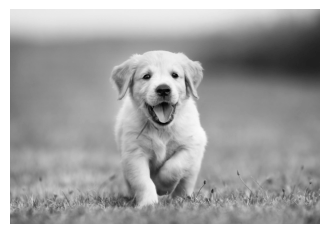

In [14]:
show_img(img_grey.cpu(), cmap='gray')

### Float

In [15]:
img_grey.zero_()
for i in range(1000): module.rgb_to_grayscale(imgc,  img_grey, 1, False)
for i in range(10): module.rgb_to_grayscale(imgc,  img_grey, 1, True)
assert_equal(img_grey_gs, img_grey.cpu())

elTime (ns): 29.70
elTime (ns): 28.67
elTime (ns): 29.70
elTime (ns): 29.70
elTime (ns): 29.70
elTime (ns): 29.70
elTime (ns): 29.89
elTime (ns): 29.70
elTime (ns): 29.70
elTime (ns): 29.70


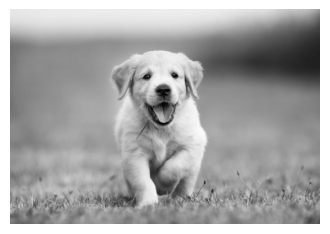

In [16]:
show_img(img_grey.cpu(), cmap='gray')

## Int

In [17]:
img_grey.zero_()
for i in range(1000): module.rgb_to_grayscale(imgc,  img_grey, 2, False)
for i in range(10): module.rgb_to_grayscale(imgc,  img_grey, 2, True)
assert_equal(img_grey_gs, img_grey.cpu())

elTime (ns): 30.72
elTime (ns): 30.72
elTime (ns): 29.70
elTime (ns): 30.72
elTime (ns): 30.72
elTime (ns): 30.75
elTime (ns): 30.72
elTime (ns): 30.72
elTime (ns): 31.49
elTime (ns): 30.72


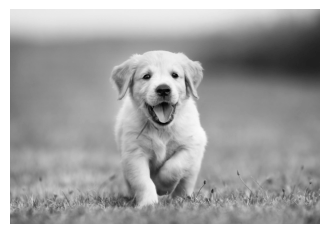

In [18]:
show_img(img_grey.cpu(), cmap='gray')

## Float with coalesced reads/writes

In [19]:
img_grey.zero_()
for i in range(1000): module.rgb_to_grayscale(imgc,  img_grey, 3, False)
for i in range(10): module.rgb_to_grayscale(imgc,  img_grey, 3, True)
assert_equal(img_grey_gs, img_grey.cpu())

elTime (ns): 26.62
elTime (ns): 26.62
elTime (ns): 27.65
elTime (ns): 27.65
elTime (ns): 27.65
elTime (ns): 27.58
elTime (ns): 27.65
elTime (ns): 26.62
elTime (ns): 27.42
elTime (ns): 27.42


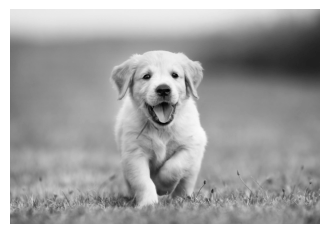

In [20]:
show_img(img_grey.cpu(), cmap='gray')